In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

In [2]:
def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

In [3]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INOUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'
# 이건 전전날에 다 만들어 놓은것들

In [4]:
# 데이터를 불러오자
train_input = np.load(open(DATA_IN_PATH + TRAIN_INOUT_DATA, 'rb'))  # numpy로 들어가있으므로, read binary
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))

# 전처리 했던 설정값을.
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))  # json 값으로 넣어뒀음

In [5]:
print(train_input.shape)
print(train_label.shape)

#  ptl값은 174  -> 미디엄값으로 했었던거 기억나길.  -> 패딩했었음

(25000, 174)
(25000,)


In [6]:
# 모델을 위한 하이퍼 파라미터를 해보자
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

model_name = 'rnn_classifier_en'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
         'vocab_size': prepro_configs['vocab_size'],
         'embedding_dimension': 100,
         'dropout_rate': 0.2,   # drop out 비율 20%
         'lstm_dimension': 150,
         'dense_dimension': 150,
         'output_dimension': 1}

### 모델 선언
- LSTM 각 단계에서 현재 정보는 input state, 이전 정보는 hidden state 라 함  
- LSTM 의 매개변수 중 return_sequences 은 hidden state 의 반환값을 결정하는데  
- false 일 경우 predict 시 마지막 hidden state만 출력됨  
- true 일 경우 각 time step 별 모든 hidden state 를 출력함  
- 이전의 기록들이 다음 레이어로 들어가기 때문에 LSTM레이어끼리 엮기 위해서는 return_sequence를 사용하여야 함 

In [7]:
class RNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):   # dict 데이터를 패킹해서 받을때는 별 2개** 써야함  /  일반은 1개*
        super(RNNClassifier, self).__init__(name=kargs['model_name'])
        # self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],  # 이러면 에러남. +1 해줘야함
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'] + 1,
                                         output_dim=kargs['embedding_dimension'])
        self.lstm_1_layer = layers.LSTM(kargs['lstm_dimension'],
                                       return_sequences=True)  # 겹겹이 줄떄는 얘를 True로 줘서 싸야한다는 것
        
        # lstml을 2개 쓸건데, 얘를 2번째로 넘겨야 학습이 됨
        
        self.lstm_2_layer = layers.LSTM(kargs['lstm_dimension'])
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(kargs['dense_dimension'], activation=tf.keras.activations.tanh)  # 출력
                                                                    # activation에 .tanh 대신 'tanh' 써도 됨
        self.fc2 = layers.Dense(kargs['output_dimension'], activation=tf.keras.activations.sigmoid)
        
        # 이렇게 일단 def 선언을 끝남
        # def는 층 정의만 한것
    
    # 실제 층을 쌓는건 call 함수
    # 입력 = x
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)   # 들어온놈을 dropout으로 넘기겠다
        x = self.lstm_1_layer(x)  # 1번째 레이어에다 넣겠다.
        x = self.lstm_2_layer(x)  # 2번째 레이어로 연결 시키겠다
        x = self.dropout(x)  # 그러고서 self.dropout을 한번 더 붙이겠다
        x = self.fc1(x)  # fc1 = Dense 층  에다 집어 넣고
        x = self.dropout(x)  # dropout 한번 더
        x = self.fc2(x)  # fc2에 집어넣음
            
        return x   # 그리고 x 반환
            # 그러면 완성

In [8]:
model = RNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              #loss=tf.keras.losses.BinaryCrossentropy(),)'binary_crossentropy'  똑같다곤 하는데, 모르겠음.
                                                                            # class를 쓰는게 정신건강에 좋음
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [9]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3)
# patience=3 -> 3번까지 해서 향상되지 않으면 멈추는 것
# min_delta -> 최소 향상된 범위가 0.0001보다 높게 나와야 향상된걸로 치겠다. => 그보다 낮으면 향상된걸로 인정 안함
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print('{} -- Folder already exists \n'.format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)  # 없으면 만들겠다
    print('{} -- Folder create complete \n'.format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1,
                             save_best_only=True, save_weights_only=True)  # save_weights_only=True -> 가중치만 저장하겠다

# 그럼 해당 위치에 폴더가 생김

./data_out/rnn_classifier_en -- Folder already exists 



In [10]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                   validation_split=VALID_SPLIT,
                   callbacks=[earlystop_callback, cp_callback])

# 이러면 진행하다가 중간에 에러남

# 왜그러냐면, 위에서
# self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
# 여기서 +1을 안해줘서 그럼



# AttributeError: module 'h5py' has no attribute 'File'

# h5py 버전이 3.1.0 -> 바꿔봄
# pip install h5py==2.10.0 --force-reinstall
# h5py는 안깔리고, numpy가 버전이 1.19.5  ->  1.21.2  로 바뀌어버렸는데
# 실패..

# pip uninstall h5py
# pip install h5py==2.10.0
# 으로 재설치했는데, 뭔가 빨간글씨(tensorflow 관련인듯) 떳지만
# 일단 설치는 됨 (h5py=2.10.0)

Epoch 1/5
176/176 [==============================] - 17s 65ms/step - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6929 - val_accuracy: 0.5096

Epoch 00001: val_accuracy improved from -inf to 0.50960, saving model to ./data_out/rnn_classifier_en\weights.h5
Epoch 2/5
176/176 [==============================] - 10s 59ms/step - loss: 0.6805 - accuracy: 0.5345 - val_loss: 0.4860 - val_accuracy: 0.7576

Epoch 00002: val_accuracy improved from 0.50960 to 0.75760, saving model to ./data_out/rnn_classifier_en\weights.h5
Epoch 3/5
176/176 [==============================] - 11s 60ms/step - loss: 0.3408 - accuracy: 0.8566 - val_loss: 0.2773 - val_accuracy: 0.8844

Epoch 00003: val_accuracy improved from 0.75760 to 0.88440, saving model to ./data_out/rnn_classifier_en\weights.h5
Epoch 4/5
176/176 [==============================] - 11s 62ms/step - loss: 0.1876 - accuracy: 0.9304 - val_loss: 0.2784 - val_accuracy: 0.8888

Epoch 00004: val_accuracy improved from 0.88440 to 0.88880, saving model to ./d

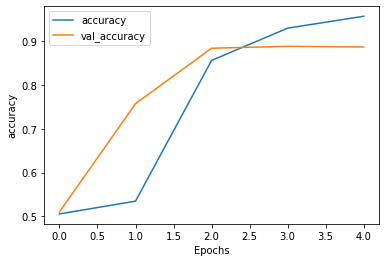

In [11]:
# 아까 그려놓은 그래프 데이터로, 그래프 그려보기
plot_graph(history, 'accuracy')

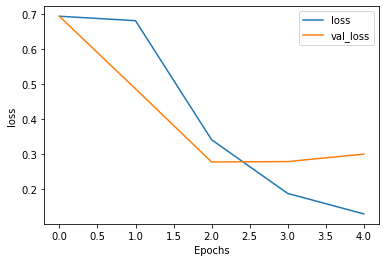

In [12]:
plot_graph(history, 'loss')

In [13]:
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])  # 패딩

In [14]:
SAVE_FILE_NM = 'weights.h5'
# best 모델을 불러오자
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [15]:
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

In [16]:
# 예측 결과
print(predictions[:10])
# 거의 1

[0.9947627  0.01606217 0.1940226  0.5260302  0.9847419  0.73394775
 0.01648752 0.7318271  0.0043338  0.5369365 ]


In [17]:
# 캐글에서 채점하려면 또 준비해야함
import pandas as pd

test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)
    
output = pd.DataFrame({'id': list(test_id), 'sentiment': list(predictions)})
output.head()

,id,sentiment
0,"""12311_10""",0.994763
1,"""8348_2""",0.016062
2,"""5828_4""",0.194023
3,"""7186_2""",0.526030
4,"""12128_7""",0.984742


In [18]:
# 그럼 이제 이걸 파일로 만들고
output.to_csv(DATA_OUT_PATH + 'review_result_rnn.csv', index=False, quoting=3)

In [19]:
# 저장이 됐으면, 캐글로 올려서 채점을 하면 됨